# Identifier les variables clés pour la prédiction des prix des vols.

I. Analyse de la corrélation des variables avec le prix

I. Tout D'abord, on va afficher une matrice de corrélation pour voir quelles variables influencent le plus le prix: PRICE_USD.

PRICE_USD          1.000000
DISTANCE           0.928928
SCHEDULED_TIME     0.923440
AIR_TIME           0.915487
ELAPSED_TIME       0.909197
TAXI_OUT           0.105702
TAXI_IN            0.072765
DAY_OF_WEEK        0.068677
MONTH              0.048404
DEPARTURE_DELAY    0.029730
WHEELS_ON          0.012213
DIVERTED           0.011980
WHEELS_OFF        -0.012752
ARRIVAL_DELAY     -0.021951
DAY               -0.112173
FLIGHT_NUMBER     -0.309373
YEAR                    NaN
CANCELLED               NaN
Name: PRICE_USD, dtype: float64


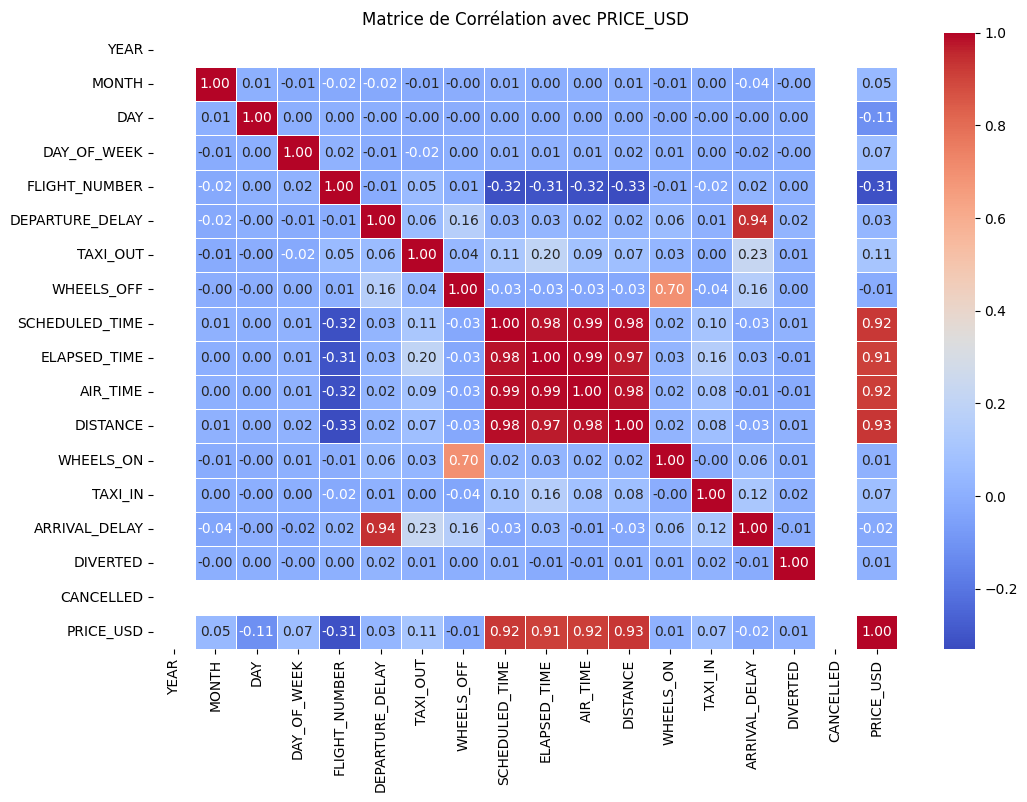

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Charger les données
df = pd.read_csv("D:/Projet_AirParadise/air_paradise_chatbot/data/enriched/data_enriched.csv", low_memory=False)

# Sélectionner uniquement les colonnes numériques
df_numeric = df.select_dtypes(include=[np.number])

# Calcul de la matrice de corrélation
correlation_matrix = df_numeric.corr()

# Trier les corrélations avec PRICE_USD
cor_price = correlation_matrix["PRICE_USD"].sort_values(ascending=False)
print(cor_price)

# Affichage de la heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Matrice de Corrélation avec PRICE_USD")
plt.show()


II. Variables les plus corrélées avec PRICE_USD (Prix du vol)

**Variables à garder (forte corrélation)**

- DISTANCE (+0.93) → Plus un vol est long, plus il est cher.
- SCHEDULED_TIME (+0.92) → Durée prévue du vol impacte directement le prix.
- AIR_TIME (+0.92) → Temps réel de vol, fortement lié à SCHEDULED_TIME.
- ELAPSED_TIME (+0.91) → Temps total de trajet (incluant taxiing).

SCHEDULED_TIME, AIR_TIME et ELAPSED_TIME sont fortement corrélés, ce qui signifie qu'ils contiennent une information similaire. Garder les trois peut introduire de la redondance dans le modèle.

Garder SHEDULED_TIME est la meilleure option, car elle représente le temps de vol prévu selon le planning.

**Variables moyennement corrélées (potentiellement utiles)**

- TAXI_OUT (+0.13) → Temps avant le décollage, léger impact.
- TAXI_IN (+0.08) → Temps après l'atterrissage, impact faible.
- DAY_OF_WEEK (+0.06) → Petites variations de prix selon les jours (week-end).
- MONTH (+0.04) → Effet saisonnier modéré.

Nous allons garder MONTH et DAY_OF_WEEK (effet de la saisonnalité et week-end).


**Variables avec une faible ou négative corrélation**

- FLIGHT_NUMBER (-0.30) → Pas pertinent pour la prédiction du prix.
- DAY (-0.10) → Pas d’impact clair, la date précise n’influence pas le prix.
- DEPARTURE_DELAY (+0.03) → Peu d’impact sur le prix initial.
- ARRIVAL_DELAY (-0.005) → Aucun effet sur le prix (lié à la ponctualité).
- WHEELS_ON / WHEELS_OFF (~0.00) → Pas pertinent pour la tarification.
- DIVERTED (+0.003) → Trop rare pour influencer significativement le prix.

Nous allons Supprimer ces variables car elles n’apportent pas d’information utile.



**Variables catégorielles à encoder**

- AIRLINE (Compagnie aérienne)
- ORIGIN_AIRPORT (Aéroport de départ)
- DESTINATION_AIRPORT (Aéroport d’arrivée)
- SCHEDULED_DEPARTURE (Heure de départ → matin/après-midi/soir)

Nous allons Encoder ces variables avec One-Hot et Hashing Encoder.

Transformer SCHEDULED_DEPARTURE en catégories (matin, journée, soir) permet d'ajouter une information temporelle utile sans introduire une variable numérique trop fine qui pourrait compliquer l'apprentissage du modèle.

In [3]:
import pandas as pd
import numpy as np
from category_encoders import HashingEncoder
from sklearn.preprocessing import OneHotEncoder

# Charger le dataset
df = pd.read_csv("D:/Projet_AirParadise/air_paradise_chatbot/data/enriched/data_enriched.csv", low_memory=False)

# Garder uniquement les colonnes utiles
cols_to_keep = ["DISTANCE", "SCHEDULED_TIME", "MONTH", "DAY_OF_WEEK", "AIRLINE", 
                "ORIGIN_AIRPORT", "DESTINATION_AIRPORT", "SCHEDULED_DEPARTURE", "PRICE_USD"]
df = df[cols_to_keep]

# Encodage One-Hot pour AIRLINE
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
airline_encoded = encoder.fit_transform(df[["AIRLINE"]])
df_airline_encoded = pd.DataFrame(airline_encoded, columns=encoder.get_feature_names_out(["AIRLINE"]))
df = pd.concat([df, df_airline_encoded], axis=1)
df.drop(columns=["AIRLINE"], inplace=True)

# Hashing Encoding pour les aéroports
hash_encoder = HashingEncoder(n_components=8)  # Réduit la dimensionnalité
df_airports = hash_encoder.fit_transform(df[["ORIGIN_AIRPORT", "DESTINATION_AIRPORT"]])
df = pd.concat([df, df_airports], axis=1)
df.drop(columns=["ORIGIN_AIRPORT", "DESTINATION_AIRPORT"], inplace=True)

# Transformation de SCHEDULED_DEPARTURE en catégories
def categorize_time(time_str):
    hour = int(time_str.split(":")[0])
    if hour < 6:
        return "matin"
    elif hour < 18:
        return "journee"
    else:
        return "soir"

df["DEPARTURE_PERIOD"] = df["SCHEDULED_DEPARTURE"].apply(categorize_time)

# Encodage de cette variable
df = pd.get_dummies(df, columns=["DEPARTURE_PERIOD"], drop_first=True)

# Suppression de l'ancienne colonne
df.drop(columns=["SCHEDULED_DEPARTURE"], inplace=True)

# Sauvegarde du dataset final
df.to_csv("D:/Projet_AirParadise/air_paradise_chatbot/data/final_dataset.csv", index=False)

print("[INFO] Dataset final prêt pour la prédiction")


[INFO] Dataset final prêt pour la prédiction
